# **Fazendo os imports das libs:**

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import nltk
import string

nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer

[nltk_data] Downloading package stopwords to /home/jv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Baixando os dataframes de treino e teste:**

In [44]:
dataframe_baixado = True
try:
    df_train = pd.read_csv('../kaggle_train.csv')
    df_test = pd.read_csv('../kaggle_test.csv')
except FileNotFoundError:
    print("Certifique-se de que os arquivos 'kaggle_train.csv' e 'kaggle_test.csv' estão na raiz do projeto.")
    dataframe_baixado = False

if (dataframe_baixado):
    print("Dataframes baixados com sucesso!")

Dataframes baixados com sucesso!


# **Visualizando os dataframes baixados:**

In [45]:
print ("Shape do dataframe de treino: ", df_train.shape)
df_train.head()

Shape do dataframe de treino:  (800, 3)


,ID,text,label
0,706,Quem vive chorando são as feministas. Graças a...,0
1,887,"doida, sem amigos, mono teta, professora, corn...",1
2,439,só tem bolsominion falando mal da T.T. \nespum...,0
3,705,"A bebida é um novo passaporte para o estrupo, ...",0
4,497,Eu jamais perdoaria. Eu seguiria a minha vida.,0


In [46]:
print ("Shape do dataframe de teste: ", df_test.shape)
df_test.head()

Shape do dataframe de teste:  (200, 2)


,ID,text
0,893,"às vezes eu penso ""putz, como eu queria uma na..."
1,555,Ja tem o video completo da audiencia no canal ...
2,858,@NOME pq vc eh antifeminista??
3,582,Não fluiu pq o Paulo mandou os mgtow pra cuca ...
4,561,Ou seja. Se for beber não transem. Ou toma um ...


# **Realizando pré-processamento do texto:**

In [47]:
# Definindo stopwords com a lib NLTK configurada para PT-BR
stop_words = list(nltk.corpus.stopwords.words('portuguese'))
                  
def pre_process_text(text: str) -> str:
    # Deixando o texto lowercase e removendo a pontuação
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    
    # Tokenização
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    
    # Filtrando os tokens:
    # 1- não pode ser stopword
    # 2- ter mais de 3 caracteres (para evitar artigos, preposições e etc)
    # 3- O 1° caractere do token não pode ser número
    tokens = [word for word in tokens
              if word not in stop_words
              and len(word) > 1
              and not word[0].isdigit()]
    
    # Reconstruindo texto
    return ' '.join(tokens)

# Aplicando o pré-processamento do texto no dataframe
df_train['text_clean'] = df_train['text'].apply(pre_process_text)
df_test['text_clean'] = df_test['text'].apply(pre_process_text)

In [50]:
# Embaralhando o dataframe de treino
df_train = df_train.sample(frac=1, random_state=42)  

# Separando features e alvo
X = df_train['text']
y = df_train['label']

# Divisão simples treino/teste local 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# TF-IDF
tfidf = TfidfVectorizer(lowercase=True)
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

print("Pré-processamento, split e TF-IDF concluídos!")
print("Número de features TF-IDF:", X_train_tfidf.shape[1])

Pré-processamento, split e TF-IDF concluídos!
Número de features TF-IDF: 3200


# **Treinamento da rede neural:**


In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

input_dim = X_train_tfidf.shape[1]

# Definindo as camadas da rede neural
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=input_dim))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilando o modelo
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Iniciando o treinamento do modelo
history = model.fit(
    X_train_tfidf,
    y_train,
    epochs=3,
    batch_size=32,
    validation_data=(X_val_tfidf, y_val),
)

Epoch 1/3


/home/jv/Documentos/GitHub/Projetos-Topicos-Avancados-em-IA/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-09-24 04:26:16.661191: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7750 - loss: 0.6454 - val_accuracy: 0.8375 - val_loss: 0.5681
Epoch 2/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8359 - loss: 0.4747 - val_accuracy: 0.8375 - val_loss: 0.4304
Epoch 3/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8359 - loss: 0.3518 - val_accuracy: 0.8375 - val_loss: 0.4146


# **Plotando a acurácia do modelo em gráfico:**

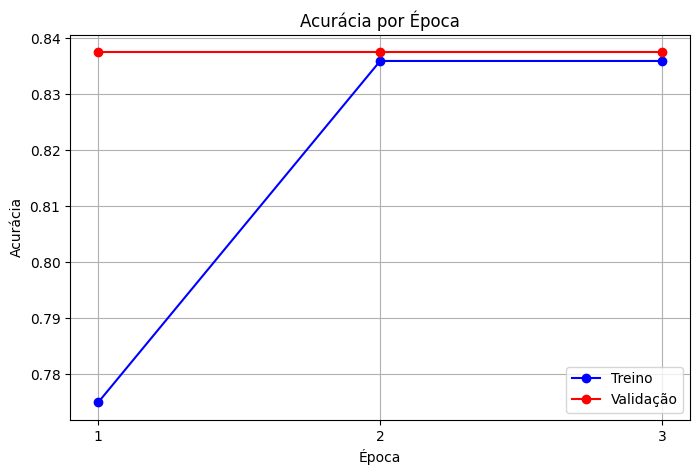

In [52]:
# Acurácia por época
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Plotar
plt.figure(figsize=(8,5))
plt.plot(epochs, acc, 'bo-', label='Treino')
plt.plot(epochs, val_acc, 'ro-', label='Validação')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

# **Análise da predição do nosso modelo por meio da matriz de confusão:**

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


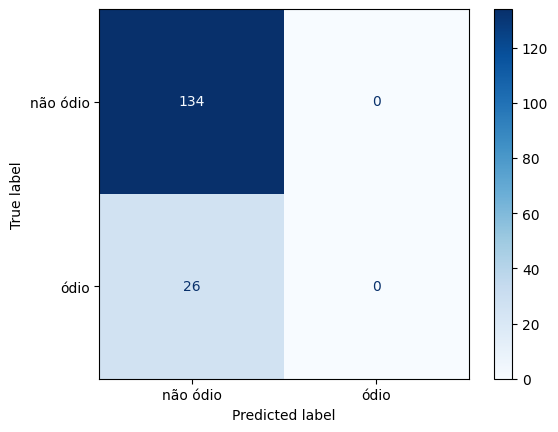

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Fazendo predições no conjunto de validação
y_pred_probs = model.predict(X_val_tfidf)

# Convertendo probabilidades para classes (0 ou 1)
y_pred_labels = (y_pred_probs > 0.5).astype(int).flatten()

# Plotando a matriz de confusão
cm = confusion_matrix(y_val, y_pred_labels, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["não ódio", "ódio"])
disp.plot(cmap="Blues")
plt.show()

# **Análise da distribuição das classes no dataframe de treino:**

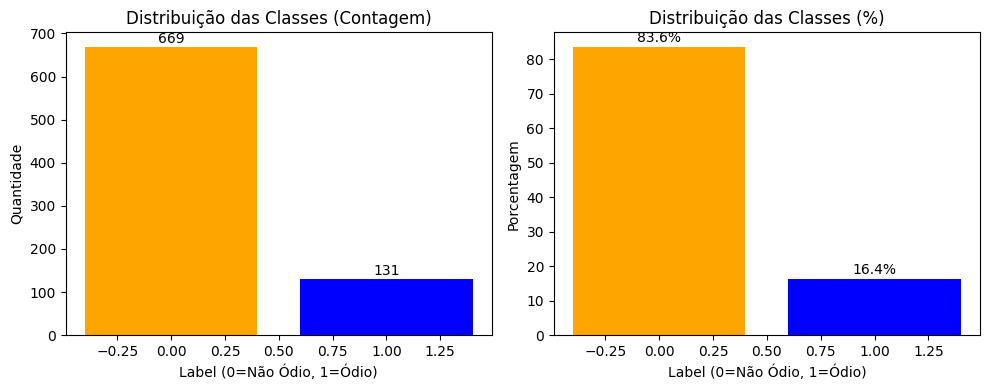

In [55]:
# Contagem e porcentagem
class_counts = df_train['label'].value_counts()
class_percent = df_train['label'].value_counts(normalize=True) * 100

# Criar figura com 2 gráficos
fig, axes = plt.subplots(1, 2, figsize=(10,4))

# --- Gráfico 1: Contagem ---
axes[0].bar(class_counts.index, class_counts.values, color=['orange','blue'])
axes[0].set_title("Distribuição das Classes (Contagem)")
axes[0].set_xlabel("Label (0=Não Ódio, 1=Ódio)")
axes[0].set_ylabel("Quantidade")
# Adicionar valores
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 1, str(v), ha='center', va='bottom')

# --- Gráfico 2: Porcentagem ---
axes[1].bar(class_percent.index, class_percent.values, color=['orange','blue'])
axes[1].set_title("Distribuição das Classes (%)")
axes[1].set_xlabel("Label (0=Não Ódio, 1=Ódio)")
axes[1].set_ylabel("Porcentagem")
# Adicionar valores
for i, v in enumerate(class_percent.values):
    axes[1].text(i, v + 0.5, f"{v:.1f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()

<h2>Conclusão:</h2>

<p style="font-size:18px;">
1. O nosso modelo consegue ter uma acurácia boa para os dados de treino, contudo os dados de validação ficaram estagnados com o passar das épocas, configurando em um caso de overfitting.<br><br>
2. Com base nas informações exibidas pela matriz de confusão, o nosso modelo possui dificuldades de identificar textos classificados com ódio, pelo dataframe.<br><br>
3. Por meio da distribuição dos dados do dataframe de treino, é possível notar que a causa da dificuldade de identificação do nosso modelo se deve ao fato do dataframe ser mal balanceado, sendo apenas composto por 16,4% de textos classificados com ódio.
</p>

In [59]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Verifique a distribuição original das classes
print('Distribuição de classes original: {}'.format(Counter(y_train)))

# Instancie o SMOTE
sm = SMOTE(random_state=42)

# Aplique o SMOTE para gerar novas amostras da classe minoritária
X_res, y_res = sm.fit_resample(X_train_tfidf, y_train)

# Verifique a nova distribuição das classes após o SMOTE
print('Distribuição de classes balanceada: {}'.format(Counter(y_res)))

Distribuição de classes original: Counter({0: 535, 1: 105})
Distribuição de classes balanceada: Counter({0: 535, 1: 535})


# **Balanceamento das classes do dataframe por meio do Oversampling:**

In [ ]:
# Filtrando o dataframe de treino com base nas classes
df_odio = df_train[df_train['label'] == 1]
df_nao_odio = df_train[df_train['label'] == 0]

# Obtendo o valor de multiplicador da linhas da classe ódio a ser balanceado 
multiplicador = len(df_nao_odio) // len(df_odio)

# Criando a base de treino balanceada
df_train_balanced = pd.concat([df_nao_odio] + [df_odio]*multiplicador, ignore_index=True)

# Embaralhando a base treino
df_train_balanced = df_train_balanced.sample(frac=1, random_state=42)  

# **Verificando novamente a distribuição das classes com o dataframe de treino balanceado:**

In [60]:
# Contagem e porcentagem
class_counts = df_train_balanced['label'].value_counts()
class_percent = df_train_balanced['label'].value_counts(normalize=True) * 100

# Criar figura com 2 gráficos
fig, axes = plt.subplots(1, 2, figsize=(10,4))

# --- Gráfico 1: Contagem ---
axes[0].bar(class_counts.index, class_counts.values, color=['orange','blue'])
axes[0].set_title("Distribuição das Classes (Contagem)")
axes[0].set_xlabel("Label (0=Não Ódio, 1=Ódio)")
axes[0].set_ylabel("Quantidade")
# Adicionar valores
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 1, str(v), ha='center', va='bottom')

# --- Gráfico 2: Porcentagem ---
axes[1].bar(class_percent.index, class_percent.values, color=['orange','blue'])
axes[1].set_title("Distribuição das Classes (%)")
axes[1].set_xlabel("Label (0=Não Ódio, 1=Ódio)")
axes[1].set_ylabel("Porcentagem")
# Adicionar valores
for i, v in enumerate(class_percent.values):
    axes[1].text(i, v + 0.5, f"{v:.1f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()

NameError: name 'df_train_balanced' is not defined

# **Separando os dados com o dataset de treino balanceado:**

In [ ]:
# Separando features e alvo
X_balanced = df_train_balanced['text']  # ou coluna de texto que você usa
y_balanced = df_train_balanced['label']

# Dividindo novamente o dataset de treino balanceado pra 2 partições treino e validação 
X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

# Reaplicando TF-IDF 
tfidf2 = TfidfVectorizer(lowercase=True)
X_train_tfidf2 = tfidf2.fit_transform(X_train2).toarray()
X_val_tfidf2 = tfidf2.transform(X_val2).toarray()


print("Pré-processamento, split e TF-IDF concluídos!")
print("Número de features TF-IDF:", X_train_tfidf2.shape[1])

Pré-processamento, split e TF-IDF concluídos!
Número de features TF-IDF: 3231


# **Reiniciando o treinamento da rede neural:**

In [ ]:
input_dim2 = X_train_tfidf2.shape[1]

# Definindo as camadas de uma nova rede neural
model2 = Sequential()
model2.add(Dense(128, activation='relu', input_dim=input_dim2))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

# Compilando o modelo
model2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

class_weight = {
    0: 1.0,  # Classe sem ódio (maioria) - peso normal
    1: 4.0   # Classe com ódio (minoria) - peso maior para dar mais importância
}

# Iniciando o treinamento do modelo
history2 = model2.fit(
    X_train_tfidf2,
    y_train2,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_tfidf2, y_val2),
    class_weight = class_weight,
)

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4893 - loss: 1.6351 - val_accuracy: 0.4943 - val_loss: 0.7638
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4843 - loss: 0.9437 - val_accuracy: 0.5208 - val_loss: 0.5731
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7415 - loss: 0.5501 - val_accuracy: 0.8792 - val_loss: 0.3515
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9724 - loss: 0.2111 - val_accuracy: 0.9472 - val_loss: 0.1536
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9875 - loss: 0.0697 - val_accuracy: 0.9396 - val_loss: 0.1485
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9965 - loss: 0.0268 - val_accuracy: 0.9509 - val_loss: 0.1390
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9964 - loss: 0.0243 - val_accuracy: 0.9358 - val_loss: 0.1654
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9977 - loss: 0.0143 - val_accuracy: 0.9509 - val_loss

# **Comparando acurácia dos modelos:**

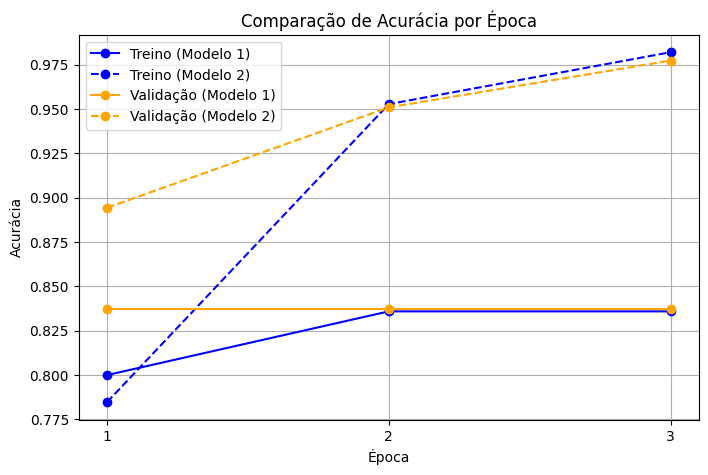

In [ ]:
# --- Histórico Modelo 1 ---
acc1 = history.history['accuracy']
val_acc1 = history.history['val_accuracy']

# --- Histórico Modelo 2 ---
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

epochs = range(1, len(acc1) + 1)

plt.figure(figsize=(8,5))

plt.plot(epochs, acc1, 'bo-', label='Treino (Modelo 1)')
plt.plot(epochs, acc2, 'bo--', label='Treino (Modelo 2)')

plt.plot(epochs, val_acc1, color='orange',  marker='o', linestyle='-', label='Validação (Modelo 1)')
plt.plot(epochs, val_acc2, color='orange',  marker='o', linestyle='--', label='Validação (Modelo 2)')

plt.title('Comparação de Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


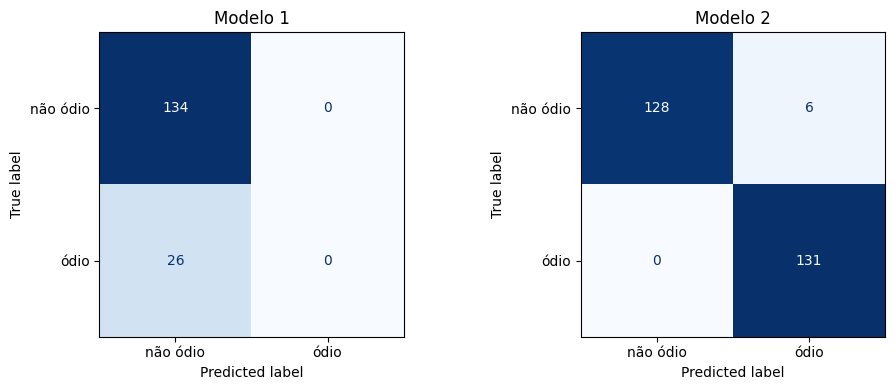

In [ ]:
# --- Modelo 1 ---
y_pred_probs1 = model.predict(X_val_tfidf)
y_pred_labels1 = (y_pred_probs1 > 0.5).astype(int).flatten()
cm1 = confusion_matrix(y_val, y_pred_labels1, labels=[0, 1])

# --- Modelo 2 ---
y_pred_probs2 = model2.predict(X_val_tfidf2)
y_pred_labels2 = (y_pred_probs2 > 0.5).astype(int).flatten()
cm2 = confusion_matrix(y_val2, y_pred_labels2, labels=[0, 1])

# --- Plotando lado a lado ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=["não ódio", "ódio"])
disp1.plot(cmap="Blues", ax=axes[0], colorbar=False)
axes[0].set_title("Modelo 1")

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=["não ódio", "ódio"])
disp2.plot(cmap="Blues", ax=axes[1], colorbar=False)
axes[1].set_title("Modelo 2")

plt.tight_layout()
plt.show()

# **Predição com os dados do dataframe de teste:**

In [ ]:
# Transformar o x_test pra TF-IDF 
X_test = df_test['text']  
X_test_tfidf = tfidf2.transform(X_test)

# Fazendo predições no dataframe de teste
y_pred_test = model2.predict(X_test_tfidf)
limiar = 0.4  
previsoes_binarias = [1 if p > limiar else 0 for p in y_pred_test]
print(previsoes_binarias)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
print(y_pred_test)

[[0.01037692]
 [0.02206129]
 [0.30664852]
 [0.09984276]
 [0.0191931 ]
 [0.45726714]
 [0.01597232]
 [0.02902357]
 [0.03608287]
 [0.00799316]
 [0.9147532 ]
 [0.17674248]
 [0.07887085]
 [0.04547916]
 [0.76792365]
 [0.02201213]
 [0.00268713]
 [0.10419483]
 [0.14284867]
 [0.28996578]
 [0.02392349]
 [0.02859413]
 [0.02912293]
 [0.6288972 ]
 [0.5714638 ]
 [0.19308497]
 [0.06533089]
 [0.16382252]
 [0.01070865]
 [0.04417941]
 [0.0208168 ]
 [0.01212584]
 [0.0493307 ]
 [0.07041609]
 [0.8470832 ]
 [0.03413934]
 [0.02351934]
 [0.00997694]
 [0.00741097]
 [0.06845107]
 [0.05867699]
 [0.7840536 ]
 [0.06000022]
 [0.08135486]
 [0.87933874]
 [0.00959999]
 [0.9885361 ]
 [0.05173732]
 [0.01026394]
 [0.14338109]
 [0.01313754]
 [0.4548833 ]
 [0.01154589]
 [0.10582905]
 [0.55481523]
 [0.12410881]
 [0.01763338]
 [0.00940137]
 [0.15205196]
 [0.0153492 ]
 [0.22608587]
 [0.00736415]
 [0.12665987]
 [0.9600328 ]
 [0.01909899]
 [0.00937205]
 [0.0482745 ]
 [0.45954332]
 [0.01187456]
 [0.02087616]
 [0.03129176]
 [0.03

In [ ]:
# df_saida = pd.DataFrame({
#     'ID' : df_test['ID'],
#     'label' : previsoes_binarias
# })

# #Salvar em CSV
# df_saida.to_csv("submission.csv", index=False)

# print("CSV criado com sucesso!")
# df_saida.head()